In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pingouin

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [4]:
data_et_fixCal = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et_fixCal.csv')
data_trial_fixCal = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial_fixCal.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et_fixCal)],
        [len(data_trial_fixCal)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et_fixCal', 
        'data_trial_fixCal', 
        'data_subject'
          ]
)
print(overview)

                   length
data_et_fixCal     389064
data_trial_fixCal    9556
data_subject           61


# Clean

In [5]:
NTrials = data_trial_fixCal.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0


In [6]:
cleanSubjects = data_subject.loc[
        (data_subject['status']=='APPROVED') &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ]
cleanSubjects.unique()

array([103,  11,  13,  19,  24,  25,  28,  30,  32,  36,  37,   4,  41,
        42,  43,  45,  47,   5,  58,  59,   6,  63,  66,  67,   7,  70,
        74,  80,  81,  85,  91,  92,  93,  94,  96,  97], dtype=int64)

In [7]:
print('data_trial_fixCal raw: ' + str(len(data_trial_fixCal)))
data_trial_fixCal = data_trial_fixCal.loc[
    data_trial_fixCal['run_id'].isin(cleanSubjects),
    :
]
print('data_trial_fixCal cleaned: ' + str(len(data_trial_fixCal)))

data_trial_fixCal raw: 9556
data_trial_fixCal cleaned: 6934


In [8]:
print('data_et_fixCal raw: ' + str(len(data_et_fixCal)))
data_et_fixCal = data_et_fixCal.loc[
    (data_et_fixCal['x']>0) &
    (data_et_fixCal['x']<1) &
    (data_et_fixCal['y']>0) &
    (data_et_fixCal['y']<1) &
    (data_et_fixCal['t_task']>1000) &
    (data_et_fixCal['run_id'].isin(cleanSubjects)), 
    :
]
print('data_et_fixCal cleaned: ' + str(len(data_et_fixCal)))

data_et_fixCal raw: 389064
data_et_fixCal cleaned: 211763


In [9]:
print('data_subject raw: ' + str(len(data_subject)))
data_subject = data_subject.loc[data_subject['run_id'].isin(cleanSubjects), :]
print('data_subject cleaned: ' + str(len(data_subject)))
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

data_subject raw: 61
data_subject cleaned: 36


# Add variables

## Offset

In [10]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et_fixCal["offset"] = euclideanDistance(
    data_et_fixCal["x"], data_et_fixCal['x_pos'],
    data_et_fixCal["y"], data_et_fixCal['y_pos'])

In [11]:
def merge_mean_by_index(data, largeData, varName):
    if (varName + '_mean' in data.columns):
        print(varName + '_mean already added!')
    else:
        grouped = largeData.groupby(['run_id', 'trial_index'])[varName].mean() \
            .reset_index() \
            .rename(columns={varName: varName + '_mean'})
        
        data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return data

data_trial_fixCal = merge_mean_by_index(data_trial_fixCal, data_et_fixCal, 'offset')
data_trial_fixCal['offset_mean'].describe()

count    6724.000000
mean        0.155981
std         0.112398
min         0.009180
25%         0.079570
50%         0.123211
75%         0.195503
max         1.096023
Name: offset_mean, dtype: float64

In [12]:
data_subject = data_subject.merge(
    data_trial_fixCal.groupby(['run_id'])['offset_mean'].mean() \
        .reset_index(),
    on='run_id',
    how='left'
)

In [13]:
grouped = data_trial_fixCal.groupby(['run_id', 'chin'])['offset_mean'].mean() \
    .reset_index()
grouped = grouped.pivot(index='run_id', columns='chin', values='offset_mean') \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'})

data_subject = data_subject.merge(grouped, on='run_id', how='left')

## Precision

In [14]:
data_et_fixCal = merge_mean_by_index(data_et_fixCal, data_et_fixCal, 'x')
data_et_fixCal = merge_mean_by_index(data_et_fixCal, data_et_fixCal, 'y')

In [15]:
def addPrecision(data):
    if 'precision' in data.columns: 
        print('precision already added!')
    else:
        data['deviationFromAVG'] = euclideanDistance(
                data['x'], data['x_mean'], data['y'], data['y_mean']
            )
        data['deviationFromAVG_square'] = np.power(data['deviationFromAVG'], 2)
        grouped = data.groupby(['run_id', 'trial_index']).mean() \
            .reset_index()
        grouped['precision'] = np.sqrt(grouped['deviationFromAVG_square'])
        data = data.merge(
                grouped.loc[:, ['run_id', 'trial_index', 'precision']], 
                on=['run_id', 'trial_index'],
                how='left'
            )
                                
    return data

data_et_fixCal = addPrecision(data_et_fixCal)
data_et_fixCal['precision'].describe()

count    211763.000000
mean          0.083902
std           0.050432
min           0.000000
25%           0.049215
50%           0.072023
75%           0.105343
max           0.428522
Name: precision, dtype: float64

In [16]:
data_trial_fixCal = merge_mean_by_index(data_trial_fixCal, data_et_fixCal, 'precision')

In [17]:
data_subject = data_subject.merge(
    data_trial_fixCal.groupby(['run_id'])['precision_mean'].mean() \
        .reset_index(),
    on='run_id',
    how='left'
)

In [18]:
grouped = data_trial_fixCal.groupby(['run_id', 'chin'])['precision_mean'].mean() \
    .reset_index()
grouped = grouped.pivot(index='run_id', columns='chin', values='precision_mean') \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'})

data_subject = data_subject.merge(grouped, on='run_id', how='left')

# datasets for fixation task

In [19]:
data_trial_fix = data_trial_fixCal.loc[
    (data_trial_fixCal['trial_type']=='eyetracking-fix-object') &
    (data_trial_fixCal['trial_duration']==5000), 
    :
]
data_trial_fix.columns

Index(['run_id', 'chinFirst', 'trial_type', 'trial_index', 'withinTaskIndex',
       'trial_duration', 'trial_duration_exact', 'chin', 'x_pos', 'y_pos',
       'task_nr', 'window_height', 'window_width', 'positionIndex', 'x_count',
       'fps', 'offset_mean', 'precision_mean'],
      dtype='object')

In [20]:
temp = data_et_fixCal.merge(
    data_trial_fixCal.loc[:, ['run_id', 'trial_index', 'trial_duration']],
    on=['run_id', 'trial_index'],
    how='left'
)

data_et_fix = temp.loc[
    (temp['trial_type']=='eyetracking-fix-object') &
    (temp['trial_duration']==5000) & 
    (temp['run_id'].isin(data_trial_fixCal['run_id'].unique())), 
    :
]
data_et_fix.columns

Index(['x', 'y', 't', 't_task', 'run_id', 'trial_index', 'trial_type', 'x_pos',
       'y_pos', 'offset', 'x_mean', 'y_mean', 'deviationFromAVG',
       'deviationFromAVG_square', 'precision', 'trial_duration'],
      dtype='object')

# Demographics

In [21]:
for col in ['Nationality', 'Employment Status', 'webcam_fps']:
    print(pd.crosstab(index=data_subject[col],
                      columns="count")
         )
    print('\n')

col_0           count
Nationality          
Greece              2
Hungary             1
Israel              2
Italy               5
Mexico              2
Poland             10
Portugal            2
South Africa        1
Spain               2
United Kingdom      8
United States       1


col_0                                               count
Employment Status                                        
DATA EXPIRED                                            1
Full-Time                                              17
Not in paid work (e.g. homemaker', 'retired or ...      1
Other                                                   4
Part-Time                                               5
Unemployed (and job seeking)                            8


col_0       count
webcam_fps       
30.0           36




# Manipulation Check

## Followed the instructions

In [22]:
data_trial_fixCal['run_id'].unique()

array([103,  11,  13,  19,  24,  25,  28,  30,  32,  36,  37,   4,  41,
        42,  43,  45,  47,   5,  58,  59,   6,  63,  66,  67,   7,  70,
        74,  80,  81,  85,  91,  92,  93,  94,  96,  97], dtype=int64)

In [23]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin


# Gaze predictions for each position

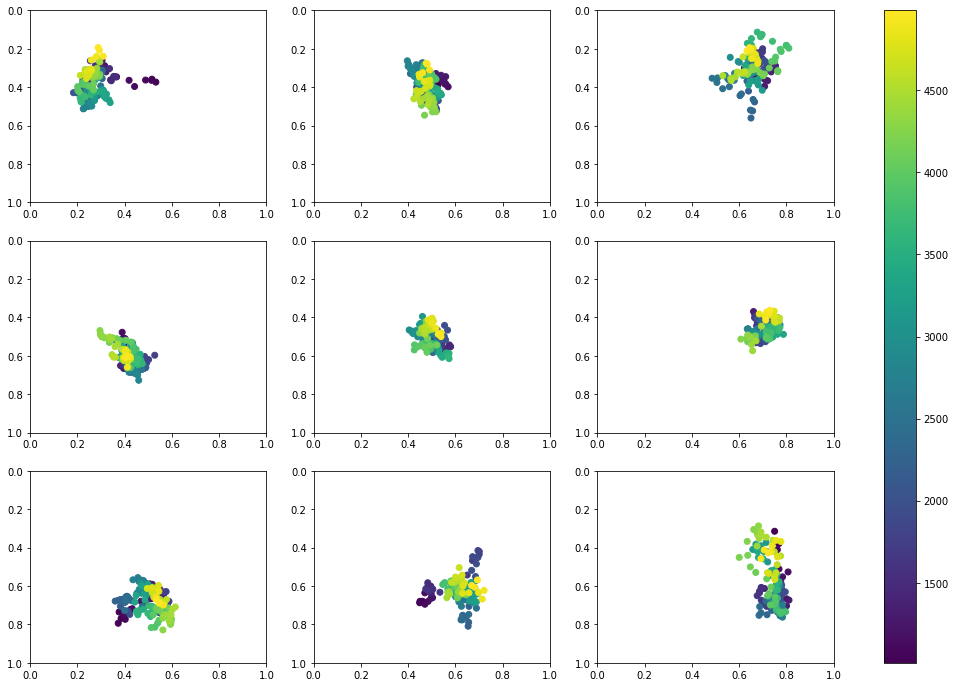

In [24]:
data_plot = data_et_fix.merge(data_trial_fix.loc[:, ['run_id', 'trial_index', 'chin']], 
                             on=['run_id', 'trial_index'], 
                             how='left')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]

for i in range(0, 9):
    axes_data = data_plot.loc[
        (data_plot['run_id']==43) & 
        (data_plot['chin']==0) &
        (data_plot['x_pos']==xPos[i]) & 
        (data_plot['y_pos']==yPos[i]), 
        :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

# fps across subjects and trials

(array([3., 1., 2., 0., 4., 0., 5., 7., 3., 5., 1., 2., 0., 2., 1.]),
 array([ 0.31503366,  2.58227958,  4.84952551,  7.11677143,  9.38401735,
        11.65126328, 13.9185092 , 16.18575512, 18.45300104, 20.72024697,
        22.98749289, 25.25473881, 27.52198474, 29.78923066, 32.05647658,
        34.32372251]),
 <a list of 15 Patch objects>)

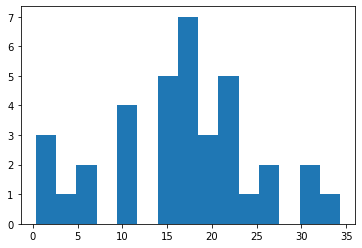

In [25]:
plt.hist(data_subject['fps'], bins=15)

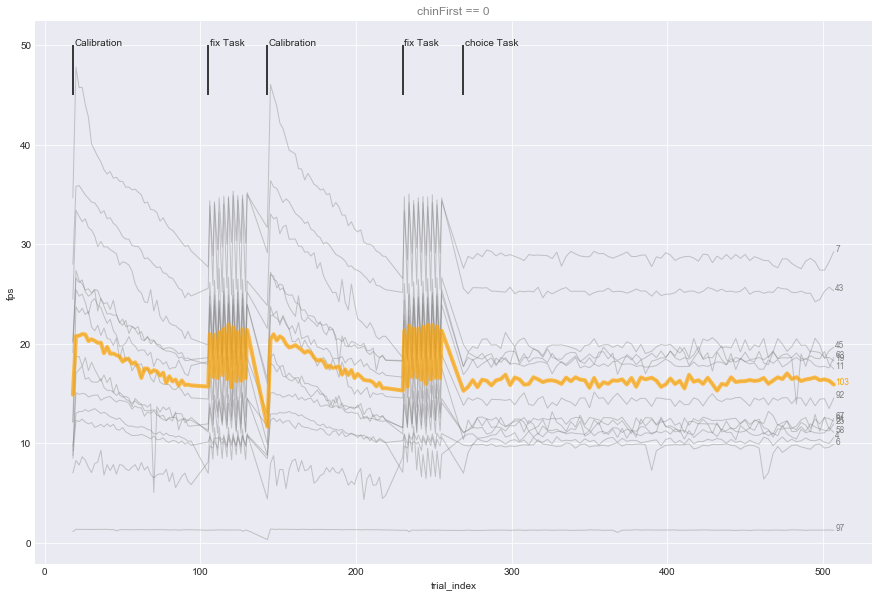

In [26]:
def spaghettiPlot(data, xVar, yVar):
    highlightedSubject = data['run_id'].unique()[0]
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        df_thisSubject = data[data['run_id']==subject]
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_fixCal.loc[data_trial_fixCal['chinFirst']==0, :],     
    'trial_index', 
    'fps')
plt.title('chinFirst == 0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(143, 45, 50, colors='k', linestyles='solid')
plt.text(143+1, 50, s='Calibration')
plt.vlines(230, 45, 50, colors='k', linestyles='solid')
plt.text(230+1, 50, s='fix Task')
plt.vlines(269, 45, 50, colors='k', linestyles='solid')
plt.text(269+1, 50, s='choice Task')
plt.show()

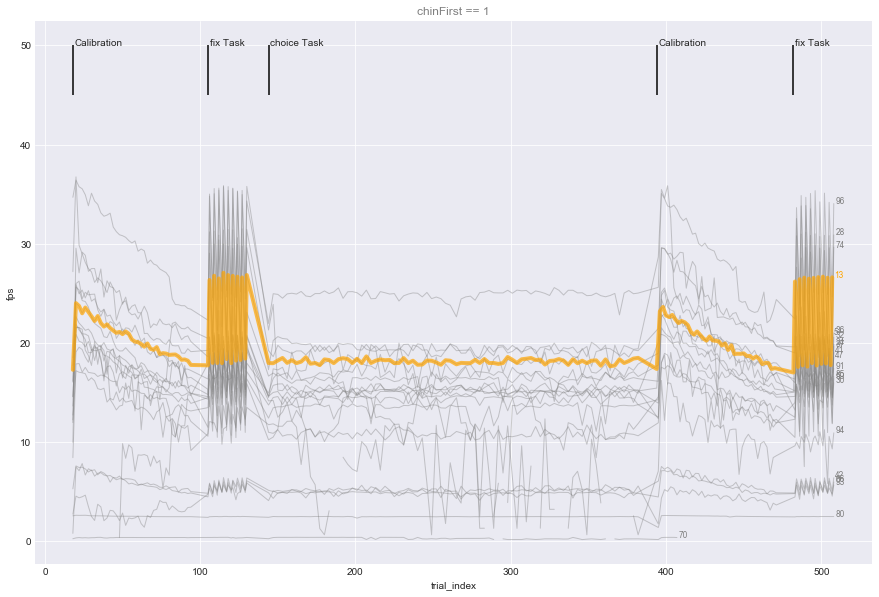

In [27]:
spaghettiPlot(
    data_trial_fixCal.loc[data_trial_fixCal['chinFirst']==1, :],     
    'trial_index', 
    'fps')
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')

plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(144, 45, 50, colors='k', linestyles='solid')
plt.text(144+1, 50, s='choice Task')
plt.vlines(394, 45, 50, colors='k', linestyles='solid')
plt.text(394+1, 50, s='Calibration')
plt.vlines(482, 45, 50, colors='k', linestyles='solid')
plt.text(482+1, 50, s='fix Task')

plt.show()

# Chin-rest effect

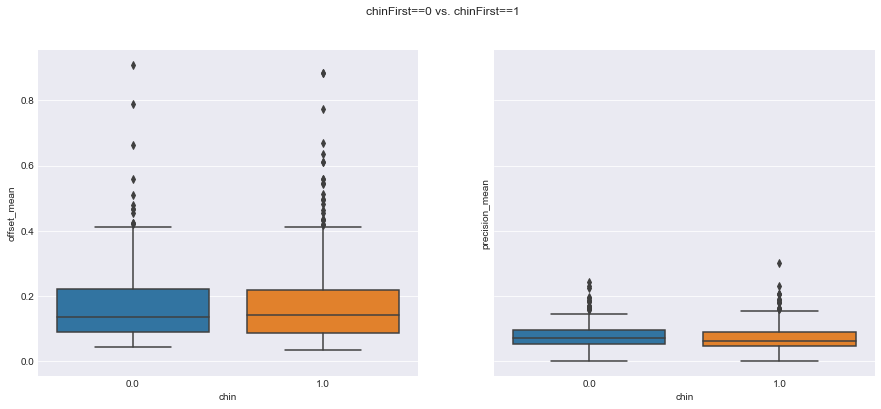

In [28]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset_mean', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision_mean', data=data_trial_fix)
   
plt.show()

In [56]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.144908,0.007609
1,offset_chin_1,0.173463,0.007298
2,precision_chin_0,0.078305,0.000401
3,precision_chin_1,0.057734,0.000246


In [30]:
scipy.stats.ttest_rel(data_subject['offset_chin_0'], data_subject['offset_chin_1'])

Ttest_relResult(statistic=-3.322487662607999, pvalue=0.0020978131887418976)

## Effect for various positions

In [67]:
grouped = data_trial_fix.groupby(['run_id', 'trial_index', 'positionIndex', 'chin']) \
    ['offset_mean'].mean() \
    .reset_index()
grouped

,run_id,trial_index,positionIndex,chin,offset_mean
0,4,106.0,3,0.0,0.401217
1,4,109.0,6,0.0,0.558058
2,4,112.0,1,0.0,0.236459
3,4,115.0,2,0.0,0.293537
4,4,118.0,5,0.0,0.389605
...,...,...,...,...,...
634,103,243.0,8,1.0,0.117263
635,103,246.0,5,1.0,0.065561
636,103,249.0,1,1.0,0.151411
637,103,252.0,2,1.0,0.196430


In [69]:
grouped = grouped.pivot(index=['run_id', 'trial_index'], columns=['chin'], values='offset_mean')

ValueError: Length of passed values is 639, index implies 2.

In [65]:
\
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'})

# data_subject = data_subject.merge(grouped, on='run_id', how='left')

ValueError: Length of passed values is 639, index implies 3.

# Offset

## offset ~ chin-rest across chinFirst

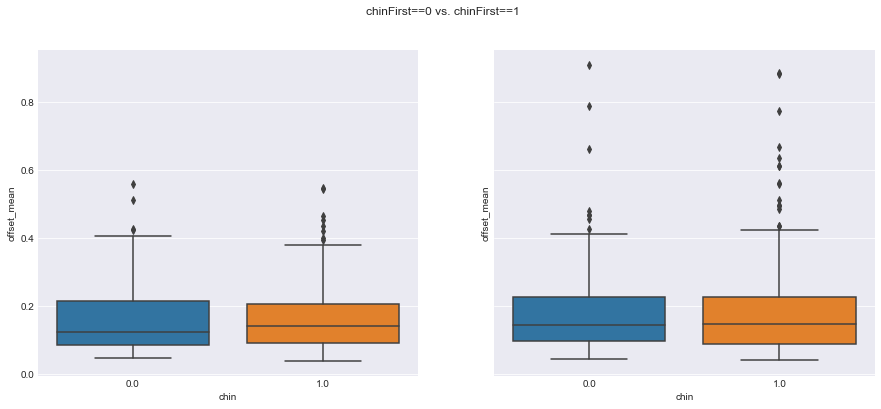

In [31]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset_mean', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset_mean', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

## offset across calibration

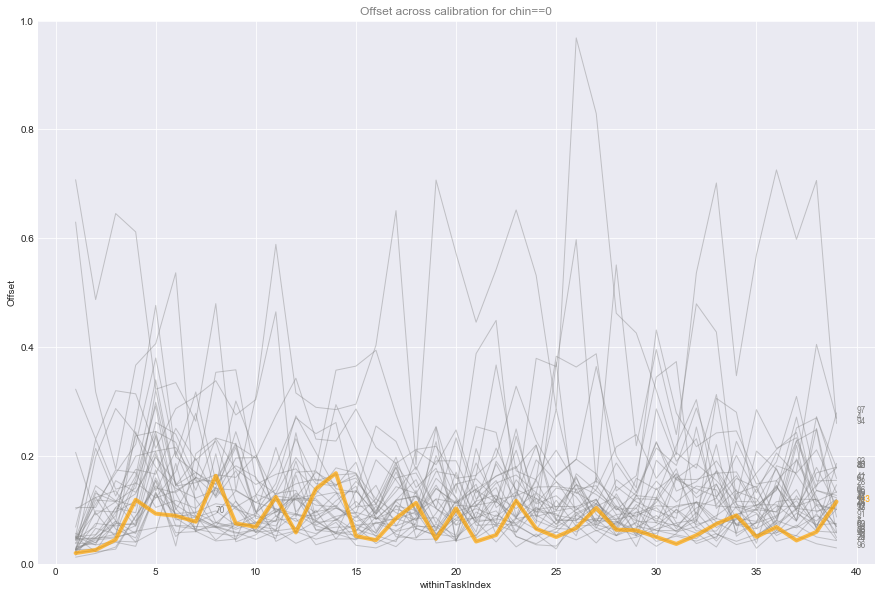

In [32]:
spaghettiPlot(
    data_trial_fixCal.loc[
        (data_trial_fixCal['trial_type']=='eyetracking-calibration') &
        (data_trial_fixCal['chin']==0),
         :
    ], 
    'withinTaskIndex', 
    'offset_mean'
)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

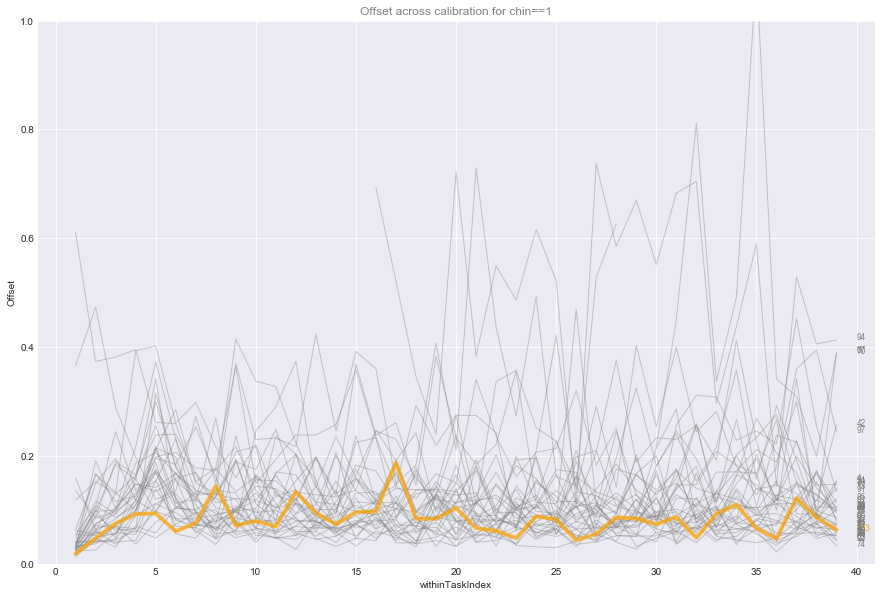

In [33]:
spaghettiPlot(
    data_trial_fixCal.loc[
        (data_trial_fixCal['trial_type']=='eyetracking-calibration') &
        (data_trial_fixCal['chin']==1),
         :
    ], 
    'withinTaskIndex', 
    'offset_mean'
)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

# Precision

## precision ~ chin-rest across chinFirst

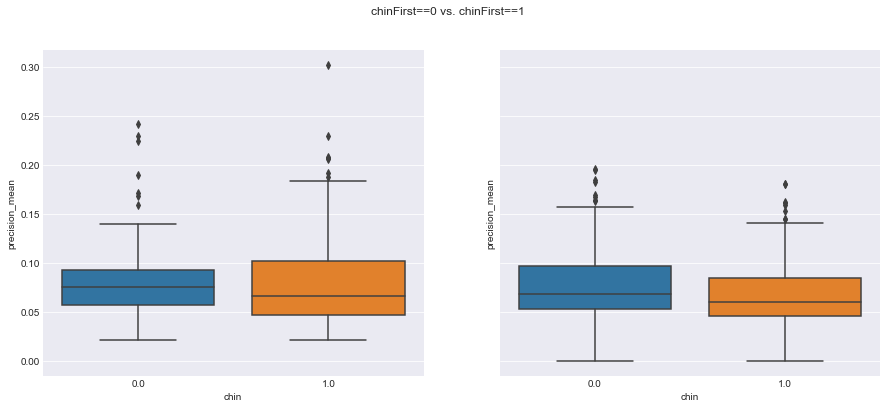

In [34]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision_mean', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision_mean', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

## Precision across calibration

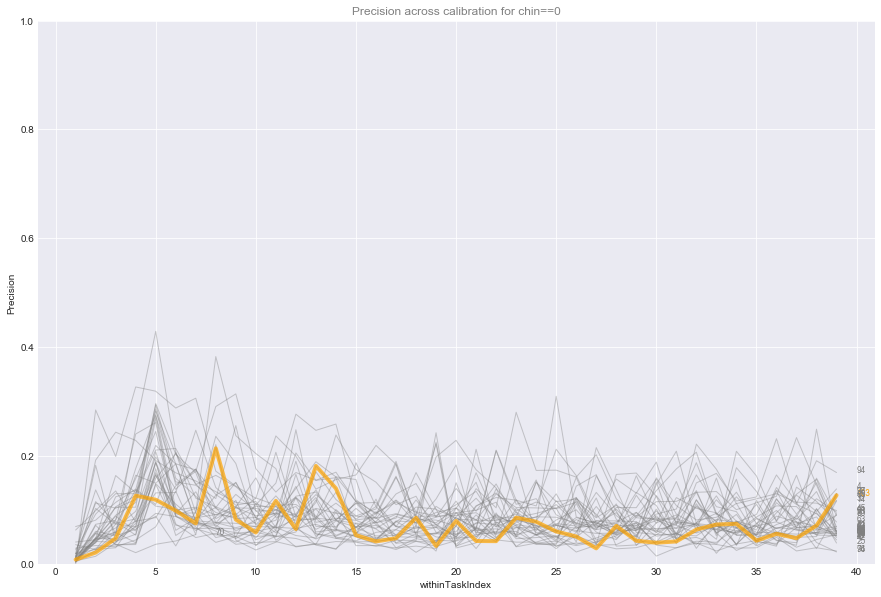

In [35]:
spaghettiPlot(
    data_trial_fixCal.loc[
        (data_trial_fixCal['trial_type']=='eyetracking-calibration') &
        (data_trial_fixCal['chin']==0),
         :
    ], 
    'withinTaskIndex', 
    'precision_mean'
)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

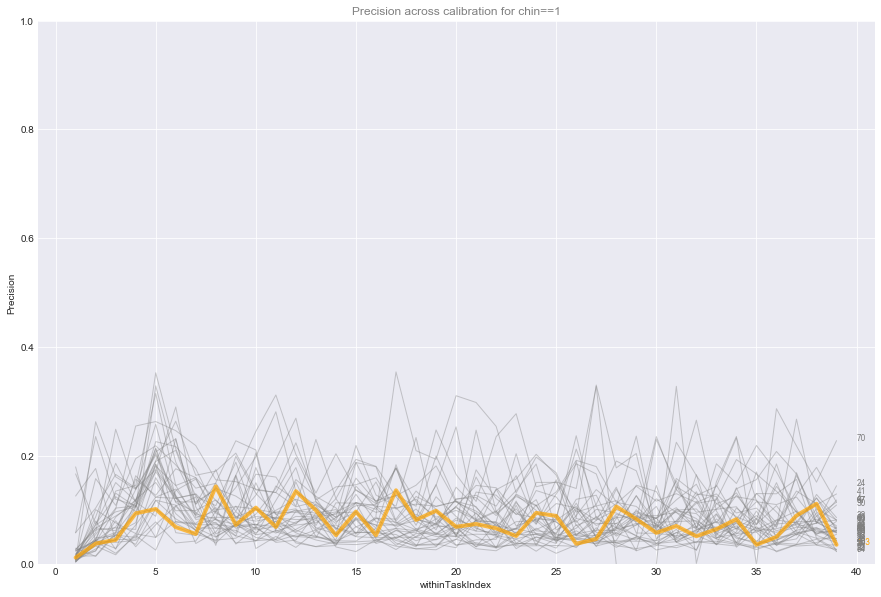

In [36]:
spaghettiPlot(
    data_trial_fixCal.loc[
        (data_trial_fixCal['trial_type']=='eyetracking-calibration') &
        (data_trial_fixCal['chin']==1),
         :
    ], 
    'withinTaskIndex', 
    'precision_mean'
)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

Text(0, 0.5, 'offset_mean')

posx and posy should be finite values
posx and posy should be finite values


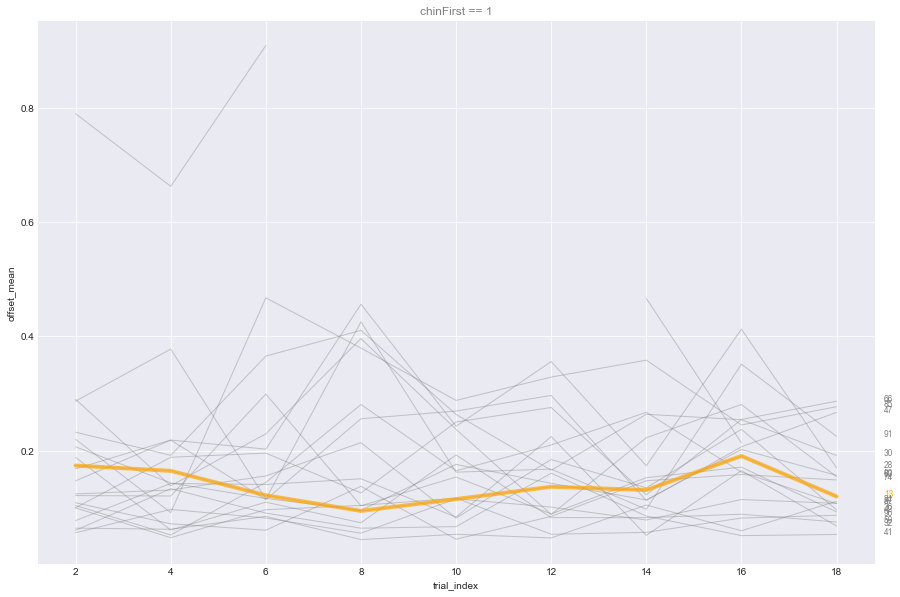

In [37]:
spaghettiPlot(
    data_trial_fix.loc[
        (data_trial_fix['chinFirst']==1) &
        (data_trial_fix['chin']==0), 
        :],     
    'withinTaskIndex', 
    'offset_mean')
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('offset_mean')

NameError: name 'data_trial_fixation' is not defined

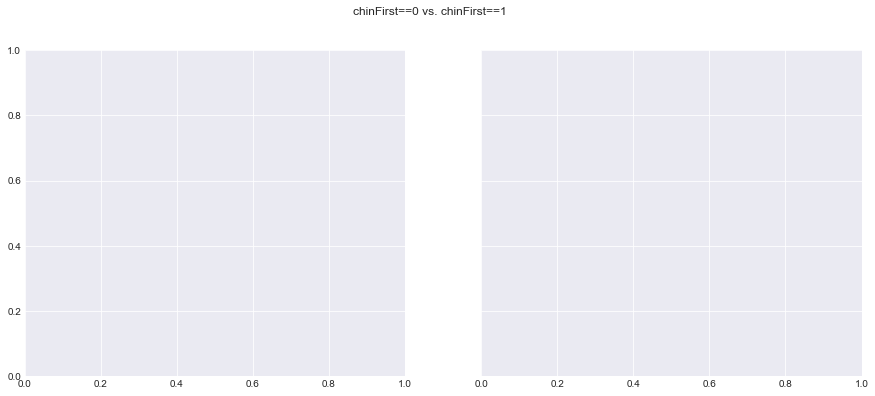

In [38]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fixation.loc[data_trial_fixation['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fixation.loc[data_trial_fixation['chinFirst']==1, :])
   
plt.show()

In [ ]:
data_et_fixation['run_id'].unique()

## Chin rest condition

In [ ]:
fixation = data_trial.loc[(data_trial['trial_type']=='eyetracking-fix-object') &
               (pd.notna(data_trial['withinTaskIndex'])), :] \
    .groupby['run_id', 'trial_index']['offset'].mean()
    .reset_index(drop=True) 
len(fixation.loc[fixation['chin']==1])

In [ ]:
data = data_trial_fixation.loc[data_trial_fixation['run_id'] == 0, :]
predictor = 'chin'
outcome = 'offset'
sample_A = data.loc[data[predictor] == 0, ['trial_index', 'offset']] \
    .drop_duplicates() \
    .reset_index(drop=True)

View(sample_A)

# data_et_choice

In [ ]:
data_et_choice = pd.read_csv('data_jupyter/data_et_choice.csv')

def cleanETData(data):
    data = data.loc[
        (
            (data['t_task'] > 1000)
        ),
        :
    ]
    return data

data_et_choice = cleanETData(data_et_choice)

In [ ]:
plotPerTrial(data_et_choice)

# Bins

%Outputs: Eye tracking bins with average proportion of looking top for
%each subject over trials when they chose the top option (binsT.csv) or
%the right option (binsB.csv). Also, the proportion of left choice based on
%the last fixation being to the left (looksL.csv) or right (looksR.csv)

cd(strcat(dataPath, '\intermediateCSVs'))
csvwrite('binsT.csv',binsT) 
csvwrite('binsB.csv',binsB)
csvwrite('looksT.csv',looksT)
csvwrite('looksB.csv',looksB)
cd(dataPath)

In [ ]:
data_et_choice = pd.read_csv('data_compiled/data_et_choice.csv')
data_trial_choice = pd.read_csv('data_compiled/data_trial_choice.csv')

In [ ]:
data_et_choice.columns

In [ ]:
# for subject in data_et_choice['run_id'].unique():
for trial in [1]: # data_thisSubject['choiceNr'].unique():
    data_thisTrial = data_et_choice.loc[
                                        (
                                            (data_et_choice['run_id']==16) &
                                            (data_thisSubject['choiceNr']==trial)
                                        ), :]  
    nLookTop = len(data_thisTrial.loc[data_thisTrial['y'] < (data_thisTrial['window_height']/2), :])
    probLookTop = nLookTop / len(data_thisTrial)
    print(probLookTop)
#     test = pd.qcut(data_thisTrial.index, q=5)

In [ ]:
binsT = [run_id, avg gaze points left ]

# Prescreeing

[Back to Navigation](#Navigation)

In [ ]:
data_raw.loc[(data_raw["success"] != '"'), ["run_id", "trial_index", "success"]]

What trials were completed too quickly?

In [ ]:
data_trial["tooQuick"] = ((data_trial["trial_duration_exact"] < 1000) & \
                         (data_trial["trial_type"] != "eyetracking-calibration") & \
                         (data_trial["stimulus"] != '"'))
data_trial.loc[0, "tooQuick"] = False
data_trial.loc[len(data_trial)-1, "tooQuick"] = False
# data_trial[(data_trial["tooQuick"]==True)]

In [ ]:
def checkFullscreen(data, XorYVariable):
    index = data.loc[
                (
                    (
                        (data["trial_type"] == 'eyetracking-calibration') |
                        (data["trial_type"] == 'eyetracking-fix-object') |
                        (data["trial_type"] == 'eyetracking-choice') 
                    ) &
                    (data[XorYVariable] != '"') &
                    (data[XorYVariable] != data[XorYVariable + '_max'])
                )
    ].index

    if len(index) > 0:
        print(XorYVariable + ' is not maxed out! Check out the following indices')
        print(index)
    else:
        print(XorYVariable + ' is checked and no variations were found')

checkFullscreen(data_trial, 'window_width')
checkFullscreen(data_trial, 'window_height')

# Hypotheses

## H1, H2, H4

### Data Cleaning

In [ ]:
# Missing values
## Row-wise
# print(df.isnull().values.sum())
## Column-wise
# print(df.isnull().sum())

In [ ]:
data_trial_choice_clean = data_trial_choice \
    .loc[(data_trial_choice['trial_duration_exact']<10000), :]

### Check for Confounders

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
                'gender',
                'ethnic', 
                'degree',
                'chinFirst', 
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='choseLL', data=data_subject)
   
plt.show()

In [ ]:
# window_diagonal_max
# age
# choiceNr
def bubblePlot(categorical_variable, distinct_variable, data):
    
    sns.set_context("talk", font_scale=1.1)
    plt.figure(figsize=(5,6))
    
    data_bubblePlot = data.loc[:, [categorical_variable, distinct_variable]]
    grouped = data_bubblePlot.groupby([distinct_variable]) \
        .count() \
        .rename(columns={categorical_variable: 'n'}) \
        .reset_index()
    data_bubblePlot = data_bubblePlot.merge(grouped, 
                                                 on=distinct_variable, 
                                                 how='left')
    data_bubblePlot['n'] = data_bubblePlot['n']     
    
    sns.scatterplot(x=categorical_variable, 
                    y=distinct_variable,
                    size='n',            
                    data=data_bubblePlot)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.xlabel(categorical_variable)
    plt.xticks([0, 1])
    plt.ylabel(distinct_variable)
    plt.tight_layout()
    plt.show()

bubblePlot(categorical_variable = 'choseLL', 
           distinct_variable = 'age', 
           data = data_trial_choice)

### Correlation

In [ ]:
correlation_columns = [
                            'trial_duration_exact',
                            'fps',
                            'k', 
                            'choiceNr',
                            'optionIndex',
                            'attributeIndex', 
                            'payneIndex',
                        ]

### Plot

In [ ]:
sns.pairplot(data_trial_choice_clean.loc[:,
        np.append(correlation_columns, ['LL_top'])
    ],
    hue='LL_top')

In [ ]:
sns.pairplot(data_trial_choice_clean.loc[:,
        np.append(correlation_columns, ['choseTop'])
    ],
    hue='choseTop')

In [ ]:
corr_matrix = np.corrcoef(data_trial_choice_clean[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [ ]:
data_trial_choice_clean[correlation_columns].rcorr()

In [ ]:
data_trial_choice_clean[correlation_columns].rcorr(upper='n')

### 4.1.1 Requirements

In [ ]:
X = data_trial_choice[["run_id", "choiceNr", "optionIndex", 'attributeIndex', 'payneIndex']]
y = 1-data_trial_choice[["choseLL"]]  

In [ ]:
def noMissingValues(data):
    null_data = X.loc[X.isnull().any(axis=1), :]
    if len(null_data) > 0:
        print('There are some missing data. Look here: \n \n')
        print(null_data)
        return(False)
    else:
        print('No missing values!')
        return(True)

In [ ]:
noMissingValues(X)